In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer


/lustre/hpc/pheno/inar/mambaforge/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
import matplotlib.pyplot as plt

In [2]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", 
                                        #   torch_dtype=torch.float16,
                                        #   device_map={"": 0}
                                        )
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.52s/it]


In [ ]:
def compute_token_entropies(model, input_ids):
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits

    probs = F.softmax(logits, dim=-1)
    entropies = -(probs * torch.log(probs)).sum(dim=-1)

    return entropies

In [69]:
def compute_entropy_temperature(model, inputs, temperature=1.0, max_new_tokens = 20):
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)

    input_len = inputs["input_ids"].shape[-1]
    outputs = outputs[:, input_len:] # remove the prompt from the generated output
    
    entropies = compute_token_entropies(model, outputs)
    return outputs, entropies

In [75]:
# prompt = "Hey, are you conscious? Can you talk to me?"
prompt = "But so far trouble had not come"

inputs = tokenizer([prompt], return_tensors="pt")

In [87]:
max_new_tokens = 100

Tlist = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 100.0]
generated_outputs = []
entropies_list = []
mean_entropy_list = [] 
for T in Tlist:
    outputs, entropies = compute_entropy_temperature(model, inputs, temperature=T, max_new_tokens=max_new_tokens)
    generated_outputs.append(outputs)
    entropies_list.append(entropies)
    mean_entropy_list.append(entropies.mean().item())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


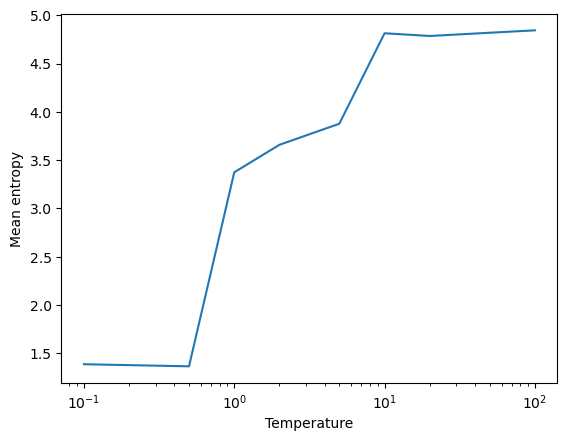

In [91]:
plt.plot(Tlist, mean_entropy_list)
plt.xlabel("Temperature")
plt.ylabel("Mean entropy")
plt.xscale("log")   

plt.show()

In [89]:
print(prompt)
for temp, outputs in zip(Tlist, generated_outputs):
    print(f'T = {temp}')
    print(tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])

But so far trouble had not come
T = 0.1
.

The first day of the new year had been a quiet one.

The second day had been a quiet one.

The third day had been a quiet one.

The fourth day had been a quiet one.

The fifth day had been a quiet one.

The sixth day had been a quiet one.

The seventh day had been a quiet one.

The eighth day had been a quiet one.

The ninth day
T = 0.5
to me. I was a good girl. I had never been in trouble. I was a good girl.

I was a good girl. I was a good girl. I was a good girl.

I was a good girl. I was a good girl. I was a good girl.

I was a good girl. I was a good girl. I was a good girl.

I was a good girl. I was a good girl. I was a good
T = 1.0
. And as for the great war, it had only reached their doorstep without any damage done. And the people were in the beginning excited and proud in the face of the great struggle. Some went down to the lines, to see the army or the navy or the ships unloading munitions. At first the war seemed such a very big t